# Imports

In [1]:
import pandas as pd
import polars as pl
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Embedding, Flatten, Input, Conv2D, MaxPooling2D, Conv1D, MaxPooling1D, LSTM, GRU, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, LearningRateScheduler
from tensorflow.keras.losses import MeanAbsoluteError

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import *

from math import remainder

# Reading in, wrangling

In [2]:
bikes = pd.read_csv('https://raw.githubusercontent.com/byui-cse/cse450-course/master/data/bikes.csv')
bikes['dteday'] = pd.to_datetime(bikes['dteday'])


def wrangle(df):
    # Break up the dates
    df['day'] = df['dteday'].dt.day
    df['month'] = df['dteday'].dt.month
    df['year'] = df['dteday'].dt.year
    df['day_of_week'] = df['dteday'].dt.day_of_week
    df['day_of_year'] = df['dteday'].dt.dayofyear
    df['is_weekend'] = df['day_of_week'] >= 5

    # Cyclical Features
    df['hour_sin'] = np.sin(2 * np.pi * df['hr'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hr'] / 24)
    df['day_of_week_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
    df['day_of_week_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
    df['day_of_year_sin'] = np.sin(2 * np.pi * df['day_of_year'] / 365)
    df['day_of_year_cos'] = np.cos(2 * np.pi * df['day_of_year'] / 365)

    # Daily feature aggregates
    df_feat = df[['dteday', 'temp_c', 'feels_like_c', 'hum', 'windspeed']].groupby('dteday').agg(['min', 'max', 'mean', 'median'])
    df_feat.columns = df_feat.columns.map('_daily_'.join)
    df_feat.reset_index(inplace=True)
    df = df.join(df_feat.set_index('dteday'), on='dteday')

    df = df.drop('dteday', axis=1)

    return df

bikes = wrangle(bikes)


# Building Model

In [3]:
feat = bikes.drop(columns = ['registered', 'casual'])

target = bikes['registered'] + bikes['casual']


X = feat
y = target


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [4]:
quant_feat = ['weathersit', 'hum', 'windspeed', 'temp_c', 'feels_like_c', 'temp_c_daily_min', 'temp_c_daily_max', 'temp_c_daily_mean', 'temp_c_daily_median', 'feels_like_c_daily_min', 'feels_like_c_daily_max', 'feels_like_c_daily_mean', 'feels_like_c_daily_median', 'hum_daily_min', 'hum_daily_max', 'hum_daily_mean', 'hum_daily_median', 'windspeed_daily_min', 'windspeed_daily_max', 'windspeed_daily_mean', 'windspeed_daily_median']

cat_feat = ['season', 'hr', 'holiday', 'workingday', 'weathersit', 'day', 'month', 'year', 'day_of_week', 'is_weekend', 'day_of_year', 'hour_sin', 'hour_cos', 'day_of_week_sin', 'day_of_week_cos', 'month_sin', 'month_cos', 'day_of_year_sin', 'day_of_year_cos']

preprocessor = ColumnTransformer(
                    transformers=[
                        ('scalable', StandardScaler(), quant_feat),
                        ('categorical', OneHotEncoder(sparse_output=False), cat_feat)],
                        remainder='passthrough'    
                        )
  
X_train_transformed = preprocessor.fit_transform(X_train)

X_test_transformed = preprocessor.transform(X_test)

In [5]:
model = Sequential([
    Dense(100, activation='relu', input_shape=(X_train_transformed.shape[1],)),
    Dense(100, activation='relu'),
    Dense(60, activation='relu'),
    Dense(30, activation='relu'),
    Dense(1, activation=None)
])

model.compile(loss='mse', metrics=[MeanAbsoluteError()], optimizer='adam')

c:\Users\Sky\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [6]:
history = model.fit(X_train_transformed, y_train, epochs=200, batch_size=32, validation_data=(X_test_transformed, y_test))


Epoch 1/200
2812/2812 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 44761.6328 - mean_absolute_error: 124.1141 - val_loss: 7170.0044 - val_mean_absolute_error: 52.3872
Epoch 2/200
2812/2812 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 6709.7612 - mean_absolute_error: 51.1253 - val_loss: 5715.3442 - val_mean_absolute_error: 46.3937
Epoch 3/200
2812/2812 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 5153.0562 - mean_absolute_error: 44.8292 - val_loss: 5060.6841 - val_mean_absolute_error: 43.5451
Epoch 4/200
2812/2812 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 4371.6738 - mean_absolute_error: 41.2051 - val_loss: 4743.7939 - val_mean_absolute_error: 42.6420
Epoch 5/200
2812/2812 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 3852.8096 - mean_absolute_error: 38.7290 - val_loss: 4253.6899 - val_mean_absolute_error: 39.4013
Epoch 6/200
2812/2812 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 3503.2197 - mean_absolute_error: 36.7946 - val_loss: 4301.6548 - val_mean_absolute_error: 38.9853
Epoch 7/200
2812/2812 ━━━━━━━━━━

In [7]:
hist = pd.DataFrame(history.history).reset_index()

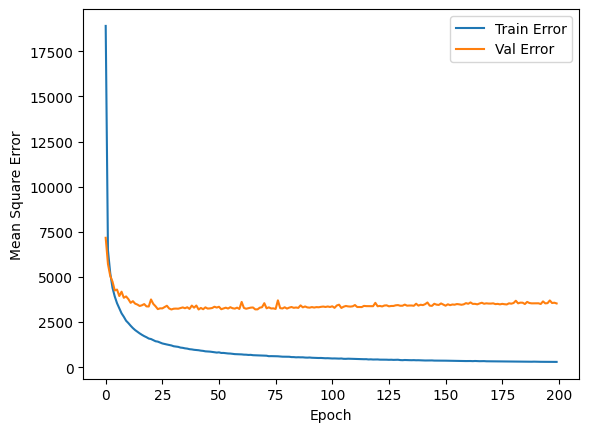

In [8]:
def plot_history():
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error')
    plt.plot(hist['index'], hist['loss'], label='Train Error')
    plt.plot(hist['index'], hist['val_loss'], label = 'Val Error')
    # plt.ylim(0, 7500)
    plt.legend()

plot_history()

# Predicting

In [9]:
predictions = model.predict(X_test_transformed)

703/703 ━━━━━━━━━━━━━━━━━━━━ 1s 817us/step


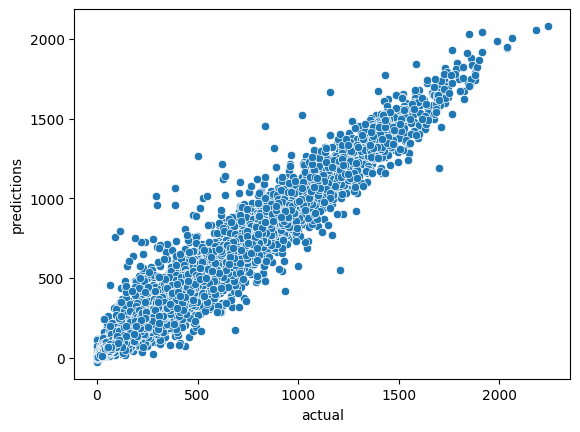

In [10]:
pred = pd.DataFrame(predictions,columns=['predictions'])
actual = pd.DataFrame(y_test,columns=['actual'])

pred['actual'] = y_test.tolist()

import seaborn as sns
xlims =(0,1000)
ax = sns.scatterplot(data=pred, x='actual', y='predictions')

plt.axis()
plt.show()

In [11]:
mean_squared_error(y_test, predictions, squared=False)

c:\Users\Sky\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


59.44521197937985

In [12]:
r2_score(y_test,predictions)

0.9699410717489719

# Holdout

In [13]:
holdout = pd.read_csv('https://raw.githubusercontent.com/byui-cse/cse450-course/master/data/biking_holdout_test_mini.csv', parse_dates=['dteday'])

holdout = wrangle(holdout)

holdout_features_transformed = preprocessor.transform(holdout)
holdout_predictions = model.predict(holdout_features_transformed)
predictions_holdout = pd.DataFrame(holdout_predictions, columns=['predictions'])
predictions_holdout.to_csv('module4-predictions.csv', index=False)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step
